<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/11_Feature_learning/11_6_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 11: Principles of Feature Learning

# 11.6 Efficient Cross-Validation via Regularization

In the previous Section we saw how with boosting based cross-validation we automatically learn the proper level of model complexity for a given dataset by optimizing a general high capacity model one unit at-a-time.   In this Section we introduce what are collectively referred to as *regularization* techniques for efficient cross-validation.  With this set of approaches we once again start with a single high capacity model, and once again adjust its complexity with respect to a training dataset via careful optimization.  However, with regularization we tune all of the units *simultaneously*, controlling how well we *optimize* its associated cost so that a minimum validation instance of the model is achieved. 

In [ ]:
# import standard libs
import os

# if on collab pull required subdirectories
if os.getenv("COLAB_RELEASE_TAG"): 
    # install github clone - allows for easy cloning of subdirectories
    !pip install github-clone
    from pathlib import Path 

    # clone datasets
    if not Path('chapter_11_datasets').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/11_Feature_learning/chapter_11_datasets
    else:
        print('chapter_11_datasets already cloned!')

    # clone library subdirectory
    if not Path('chapter_11_library').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/11_Feature_learning/chapter_11_library
    else:
        print('chapter_11_library already cloned!')

    # clone images
    if not Path('chapter_11_images').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/11_Feature_learning/chapter_11_images
    else:
        print('chapter_11_images already cloned!')

    # clone videos
    if not Path('chapter_11_videos').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/11_Feature_learning/chapter_11_videos
    else:
        print('chapter_11_videos already cloned!')


# append path for local library, data, and image import
import sys, copy
sys.path.append('./chapter_11_library') 

# backend file
from intro_general_library import superlearn_setup
import section_11_6_helpers

# data path
data_path_1 = 'chapter_11_datasets/noisy_sin_sample.csv'

# image paths
image_path_1 = "chapter_11_images/Figure_11_37.png"
image_path_2 = "chapter_11_images/Figure_11_38.png"
image_path_3 = "chapter_11_images/Figure_11_39.png"
image_path_4 = "chapter_11_images/Figure_11_40.png"
image_path_5 = "chapter_11_images/Figure_11_41.png"
image_path_6 = "chapter_11_images/Figure_11_42.png"

# video paths
video_path_1 = 'chapter_11_videos/animation_9.mp4'

# standard imports
import matplotlib.pyplot as plt
from IPython.display import Image, HTML
import autograd.numpy as np
from base64 import b64encode

def show_video(video_path, width = 1000):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={width} controls><source src="{video_url}"></video>""")

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## Regularization techniques: the big picture

Imagine for a moment that we have a simple nonlinear regression dataset, like the one shown in the top-left panel of the [Figure 11.37](#figure-11-37), and we use a high capacity model (relative to the nature of the data) made up of a sum of *universal approximators* of a single kind to fit it as

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_M\left(\mathbf{x}\right)w_M.
\label{equation:regularization-original-construct}
\end{equation}

 Suppose then that we partition this data into training and validation portions, and then train our high capacity model by *completely* optimizing the Least Squares cost over the training portion of the data.  In other words, we determine a set of parameters for our high capacity model that lie very close to a global minimum of its associated cost function.  In the top-right panel of the Figure we draw a hypothetical two dimensional illustration of the cost function associated with our high capacity model over the training data, denoting the global minimum by a blue dot and its evaluation on the function by a blue 'x'.  

Since our model has high capacity, the resulting fit provided by the parameters lying at the global minimum of our cost will produce a tuned model that is overly complex and *severely* overfits the training portion of our dataset.  In the bottom-left panel of the [Figure 11.37](#figure-11-37) we show the tuned model fit (in blue) provided by such a set of parameters, which wildly overfits the training data.  In the top-right panel we also show a set of parameters lying relatively near the global minimum as a yellow dot, and whose evaluation of the function is shown as a yellow 'x'.  This set of parameters lying in the general neighborhood of the global minimum is where the cost function is minimized over the *validation* portion of our data.  Because of this the corresponding fit (shown in the bottom-right panel in yellow) provides a much better representation of the data.

---

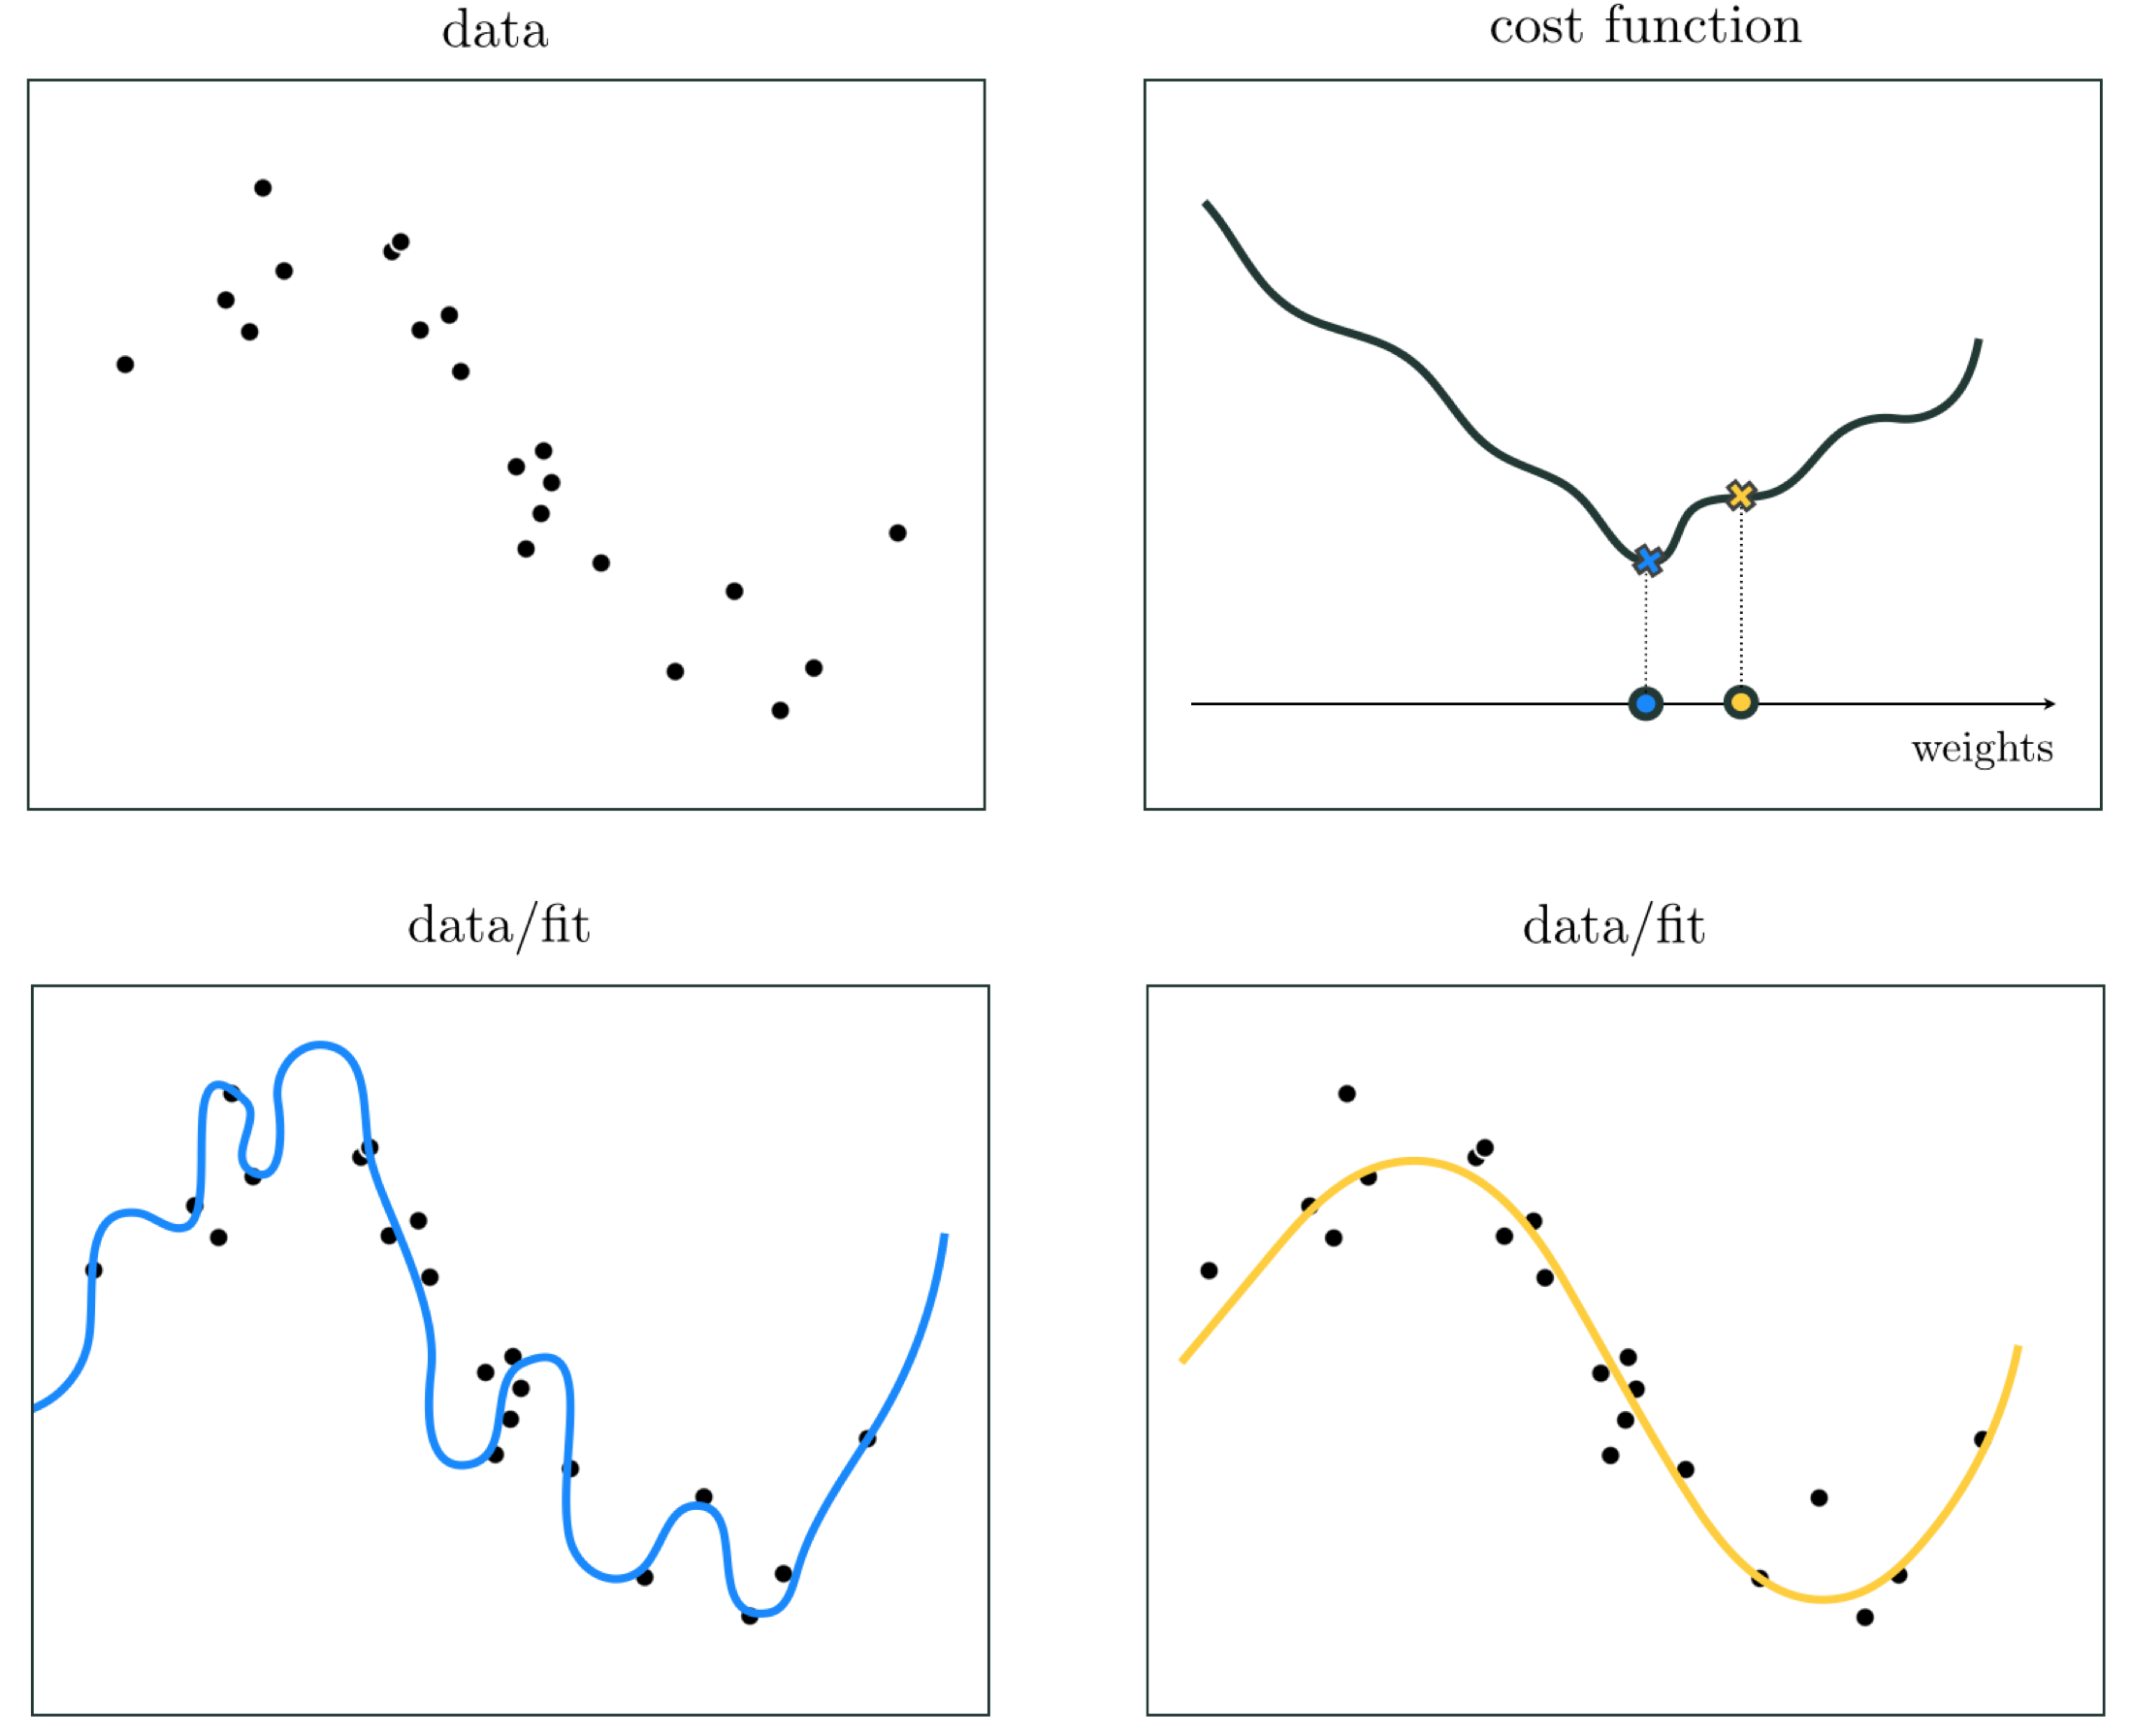

In [ ]:
Image(image_path_1)

<a id='figure-11-37'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.37 </strong> <em> 
(top row) (top-left panel) A generic nonlinear regression dataset. (top-right panel) A figurative illustration of the cost function associated with a high capacity model over the training portion of this data.  The global minimum is marked here with a blue dot (along with its evaluation by a blue 'x') and a point nearby is marked in yellow (and whose evaluation is shown as a yellow 'x').  (bottom-left panel) The original data and fit (in blue) provided by the model using parameters from the global minimum of the cost function severely overfits the training portion of the data.  (bottom-right panel)  A fit provided by the parameters corresponding to the yellow dot shown in the top-right panel minimize the cost function over the validation portion of the data, and here provide a much better fit (in yellow) to the data.  See text for further details.
</em>
</figcaption>
</figure>

---

This toy example is illustrative of a more general principal we have seen earlier in Section 11.3.2: that overfitting is due both to the *capacity* of an un-tuned model being too high *and* its corresponding cost function (over the training data) being *optimized* too well, leading to an overly complex tuned model.  Conversely, if we use a high capacity model and minimize its cost function (over the training data) the best set of parameters are those that provide minimum error over the validation portion of the data.  

This phenomenon holds true for all machine learning problems (including regression, classification, and unsupervised learning techniques like the Autoencoder) and is the motivation for general regularization-based cross-validation strategies: if proper optimization of *all parameters* of a high capacity model leads to overfitting, it can be avoided by optimizing said model *imperfectly* when validation error (not training error) is at its lowest. In other words, *regularization* in the context of cross-validation constitutes a set of approaches to cross-validation wherein we carefully tune all parameters of a high capacity model by setting them purposefully away from the global minima of its associated cost function.   This can be done in a variety of ways, and we detail the two most popular approaches below. 

##  Early stopping based regularization

With *early stopping regularization* we properly tune a high capacity model by making a run of local optimization (tuning all parameters of the model), and by using the set of weights from this run where the model achieves minimum validation error.  This idea is illustrated in the left panel of [Figure 11.38](#figure-11-38) where we employ the same prototypical cost function (associated with a high capacity model) first shown in the top-right panel of [Figure 11.38](#figure-11-38).  Here again we mark its global minimum and set of validation error minimizing weights in blue and yellow, respectively (as detailed originally in [Figure 11.37](#figure-11-37). During a run of local optimization we frequently compute training and validation errors (e.g., at each step of the optimization procedure). Thus, depending on the optimization procedure used (as detailed further below) a set of weights providing minimum validation error for a high capacity model can be determined with fine resolution.

This regularization approach is especially popular when employing high capacity deep neural network models as detailed in Section 13.7.

---

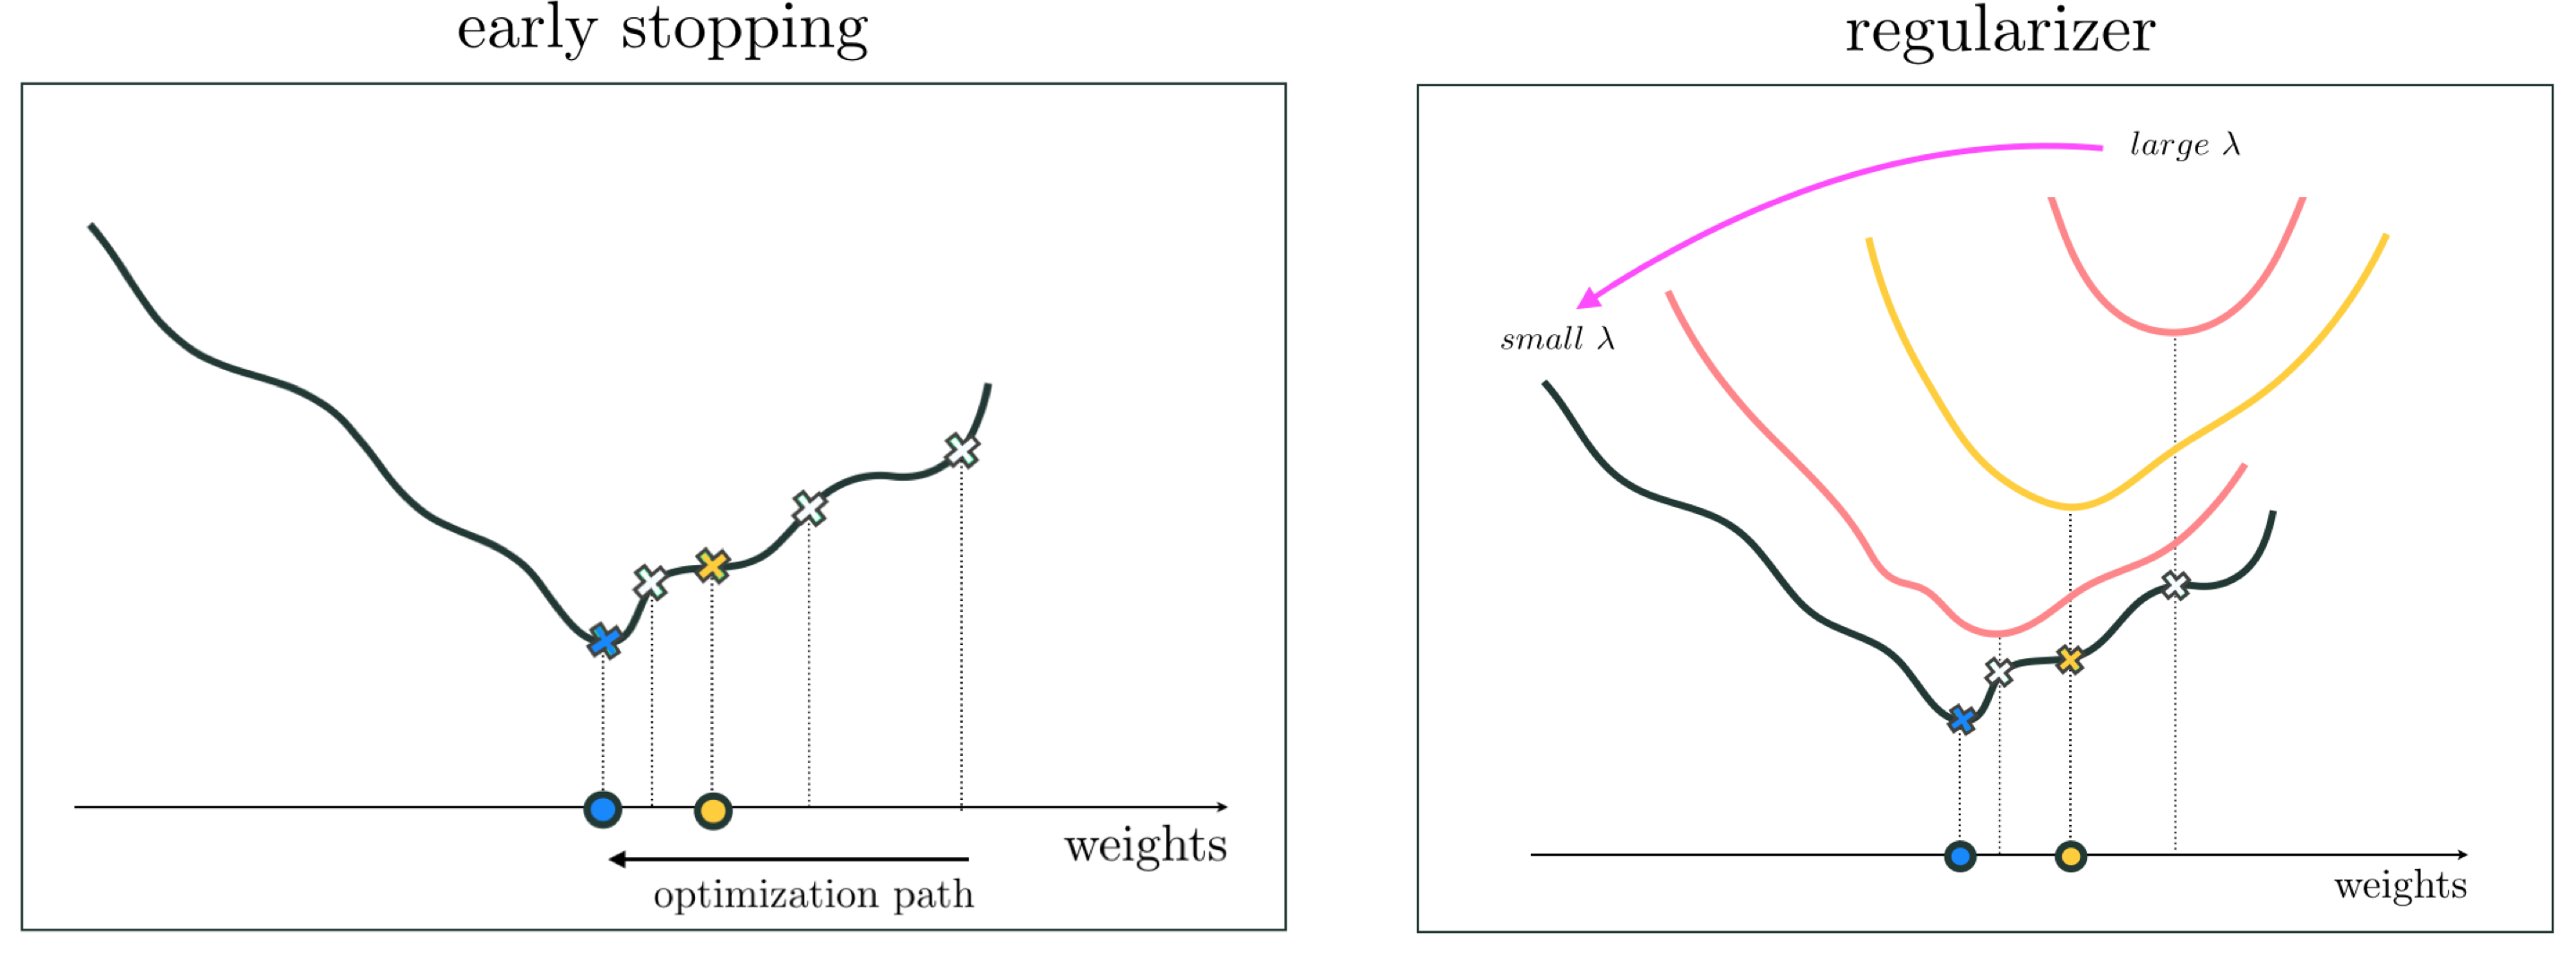

In [ ]:
Image(image_path_2)

<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.38 </strong> <em> 
(left panel) A figurative illustration of early stopping regularization applied to a prototypical cost function of a high capacity model.  We make a run of optimization - here shown to completion at the global minimum in blue - and choose the set of weights that provide a minimum validation error (shown in yellow).  (right panel) A figurative illustration of regularizer based regularization.  By adding a regularizer function to the cost associated of a high capacity model we change its shape, in particular dragging its global minima (here only one global minimum is shown) where overfitting behavior occurs away from their original location(s).  The regularized cost function can then be completely minimized to recover weights as close to / far away from the true global minima of the original cost function, depending on the choice of the regularization parameter.  This also allows for the recovery of validation error minimizing weights (by proper setting of the regularization parameter).  See text for further details.
</em>
</figcaption>
</figure>

---

Whether or not one literally stops the optimization run when minimum validation error has been reached (which can be challenging in practice given the somewhat unpredictable behavior of validation error as first noted in Section 11.4) or one runs the optimization to completion (picking the best set of weights afterwards), in either case we refer to this method as early stopping regularization.  Note that the method itself is analogous to the early stopping procedure outlined for boosting based cross-validation in Section 11.5 in that we sequentially increase the complexity of a model until minimum validation is reached.   However, here (unlike boosting) we do this by controlling how well we optimize a model's parameters *simultaneously*, as opposed to one unit at-a-time. 

Supposing that we begin our optimization with a small initial value (which we typically do; see for example, Section 3.6) the corresponding training and validation error curves will in general\footnote{Note that both can oscillate in practice depending on the optimization method used.} look like those shown in top panel of [Figure 11.38](#figure-11-38). At the start of the run the complexity of our model (evaluated at, for instance, the initial weights) is quite small, providing a large training and validation error.  As minimization proceeds, and we continue optimizing one step at-a-time, error in both training and validation portions of the data decreases while the complexity of the tuned model increases.  This trend continues up until a point when the model complexity becomes too great and overfitting begins, and validation error increases.  

---

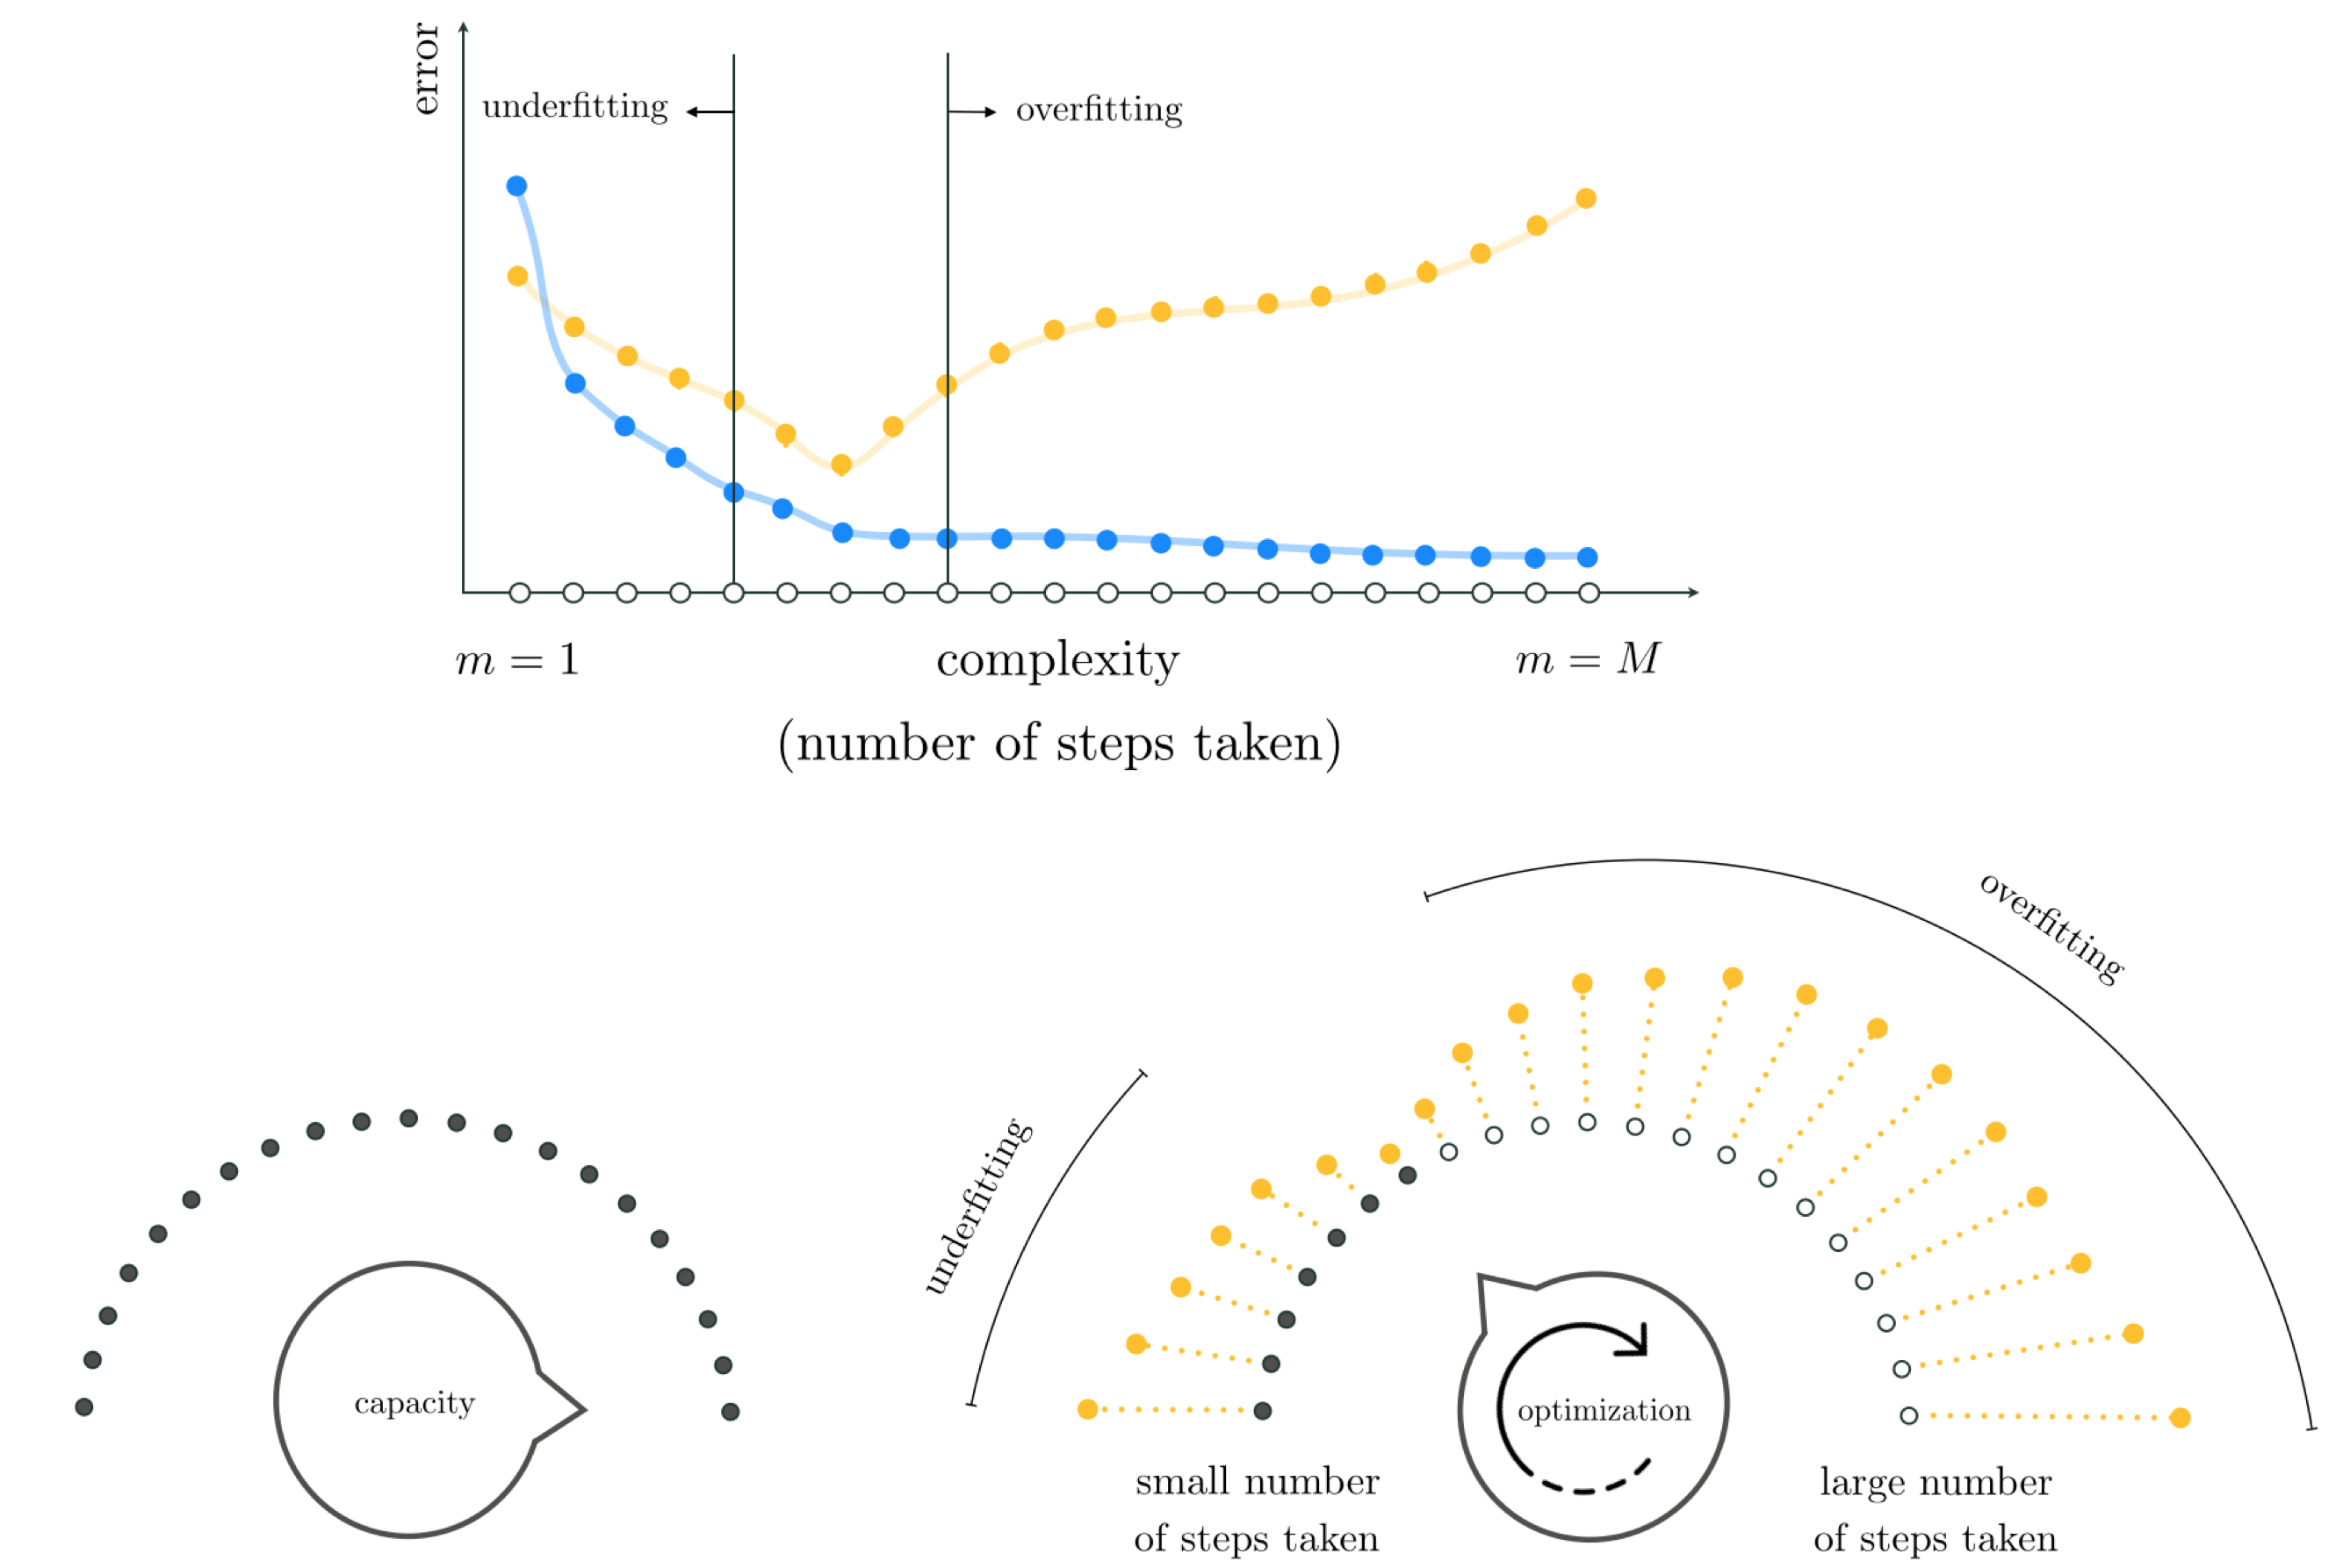

In [ ]:
Image(image_path_3)

<a id='figure-11-39'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.39 </strong> <em> 
(top panel) A prototypical pair of training / validation error curves associated with a generic run of the early stopping regularization.  (bottom-left and bottom-right panel) With early stopping we set our capacity dial all the way to the right and our optimization dial all the way to the left.  We then slowly move our optimization dial from left to right, iteratively improving the fit of our of model to the training data, adjusting all of its parameters simultaneously one step at-a-time.  As each step of optimization progresses we slowly turn the optimization dial clockwise from left to right, gradually increasing the complexity of our tuned model, in search of a tuned model with minimum validation error.  Here each notch on the optimization dial abstractly denotes a step of local optimization. See text for further details.
</em>
</figcaption>
</figure>

---

In terms of the capacity/optimization dial scheme detailed in the context of real data in Section 11.3.2, we can think of (early stopping based) regularization as beginning with our capacity dial set all the way to the right (since we employ a high capacity model) and our optimization dial all the way to the left (at the initialization of our optimization).  With this configuration - summarized visually in the bottom panel of [Figure 11.39](#figure-11-39) - we allow our optimization dial to (roughly speaking) directly govern the amount of complexity our tuned models can take (here each notch on the optimization dial denotes a single step of local optimization).  In other words, with this configuration our optimization dial becomes (roughly speaking) the ideal complexity dial described at the start of the Chapter in Section 11.1.  With early stopping we turn our optimization dial from left to right, starting at our initialization making a run of local optimization one step at-a-time, seeking out a set of parameters that provide minimum validation error for our (high capacity) model.  This is illustrated in the bottom panels of Figure 11.39, where we see our capacity dial set all the way to the right and our generic validation error curve wrapped around our optimization dial (as it now, roughly speaking, controls the complexity of each tuned model).

With an initial set of parameters $\Theta_0$, taking $M$ steps of a local optimization produces a sequence of $M+1$ parameter settings $\left\{\Theta_m\right\}_{m=0}^M$ for our model, or similarly (ignoring the initialization for the sake of illustration) a set of $M$ models of generally *increasing* complexity with respect to the training data $\left\{\text{model}\left(\textbf{x},\Theta_m\right)\right\}_{m=1}^M$.  

---

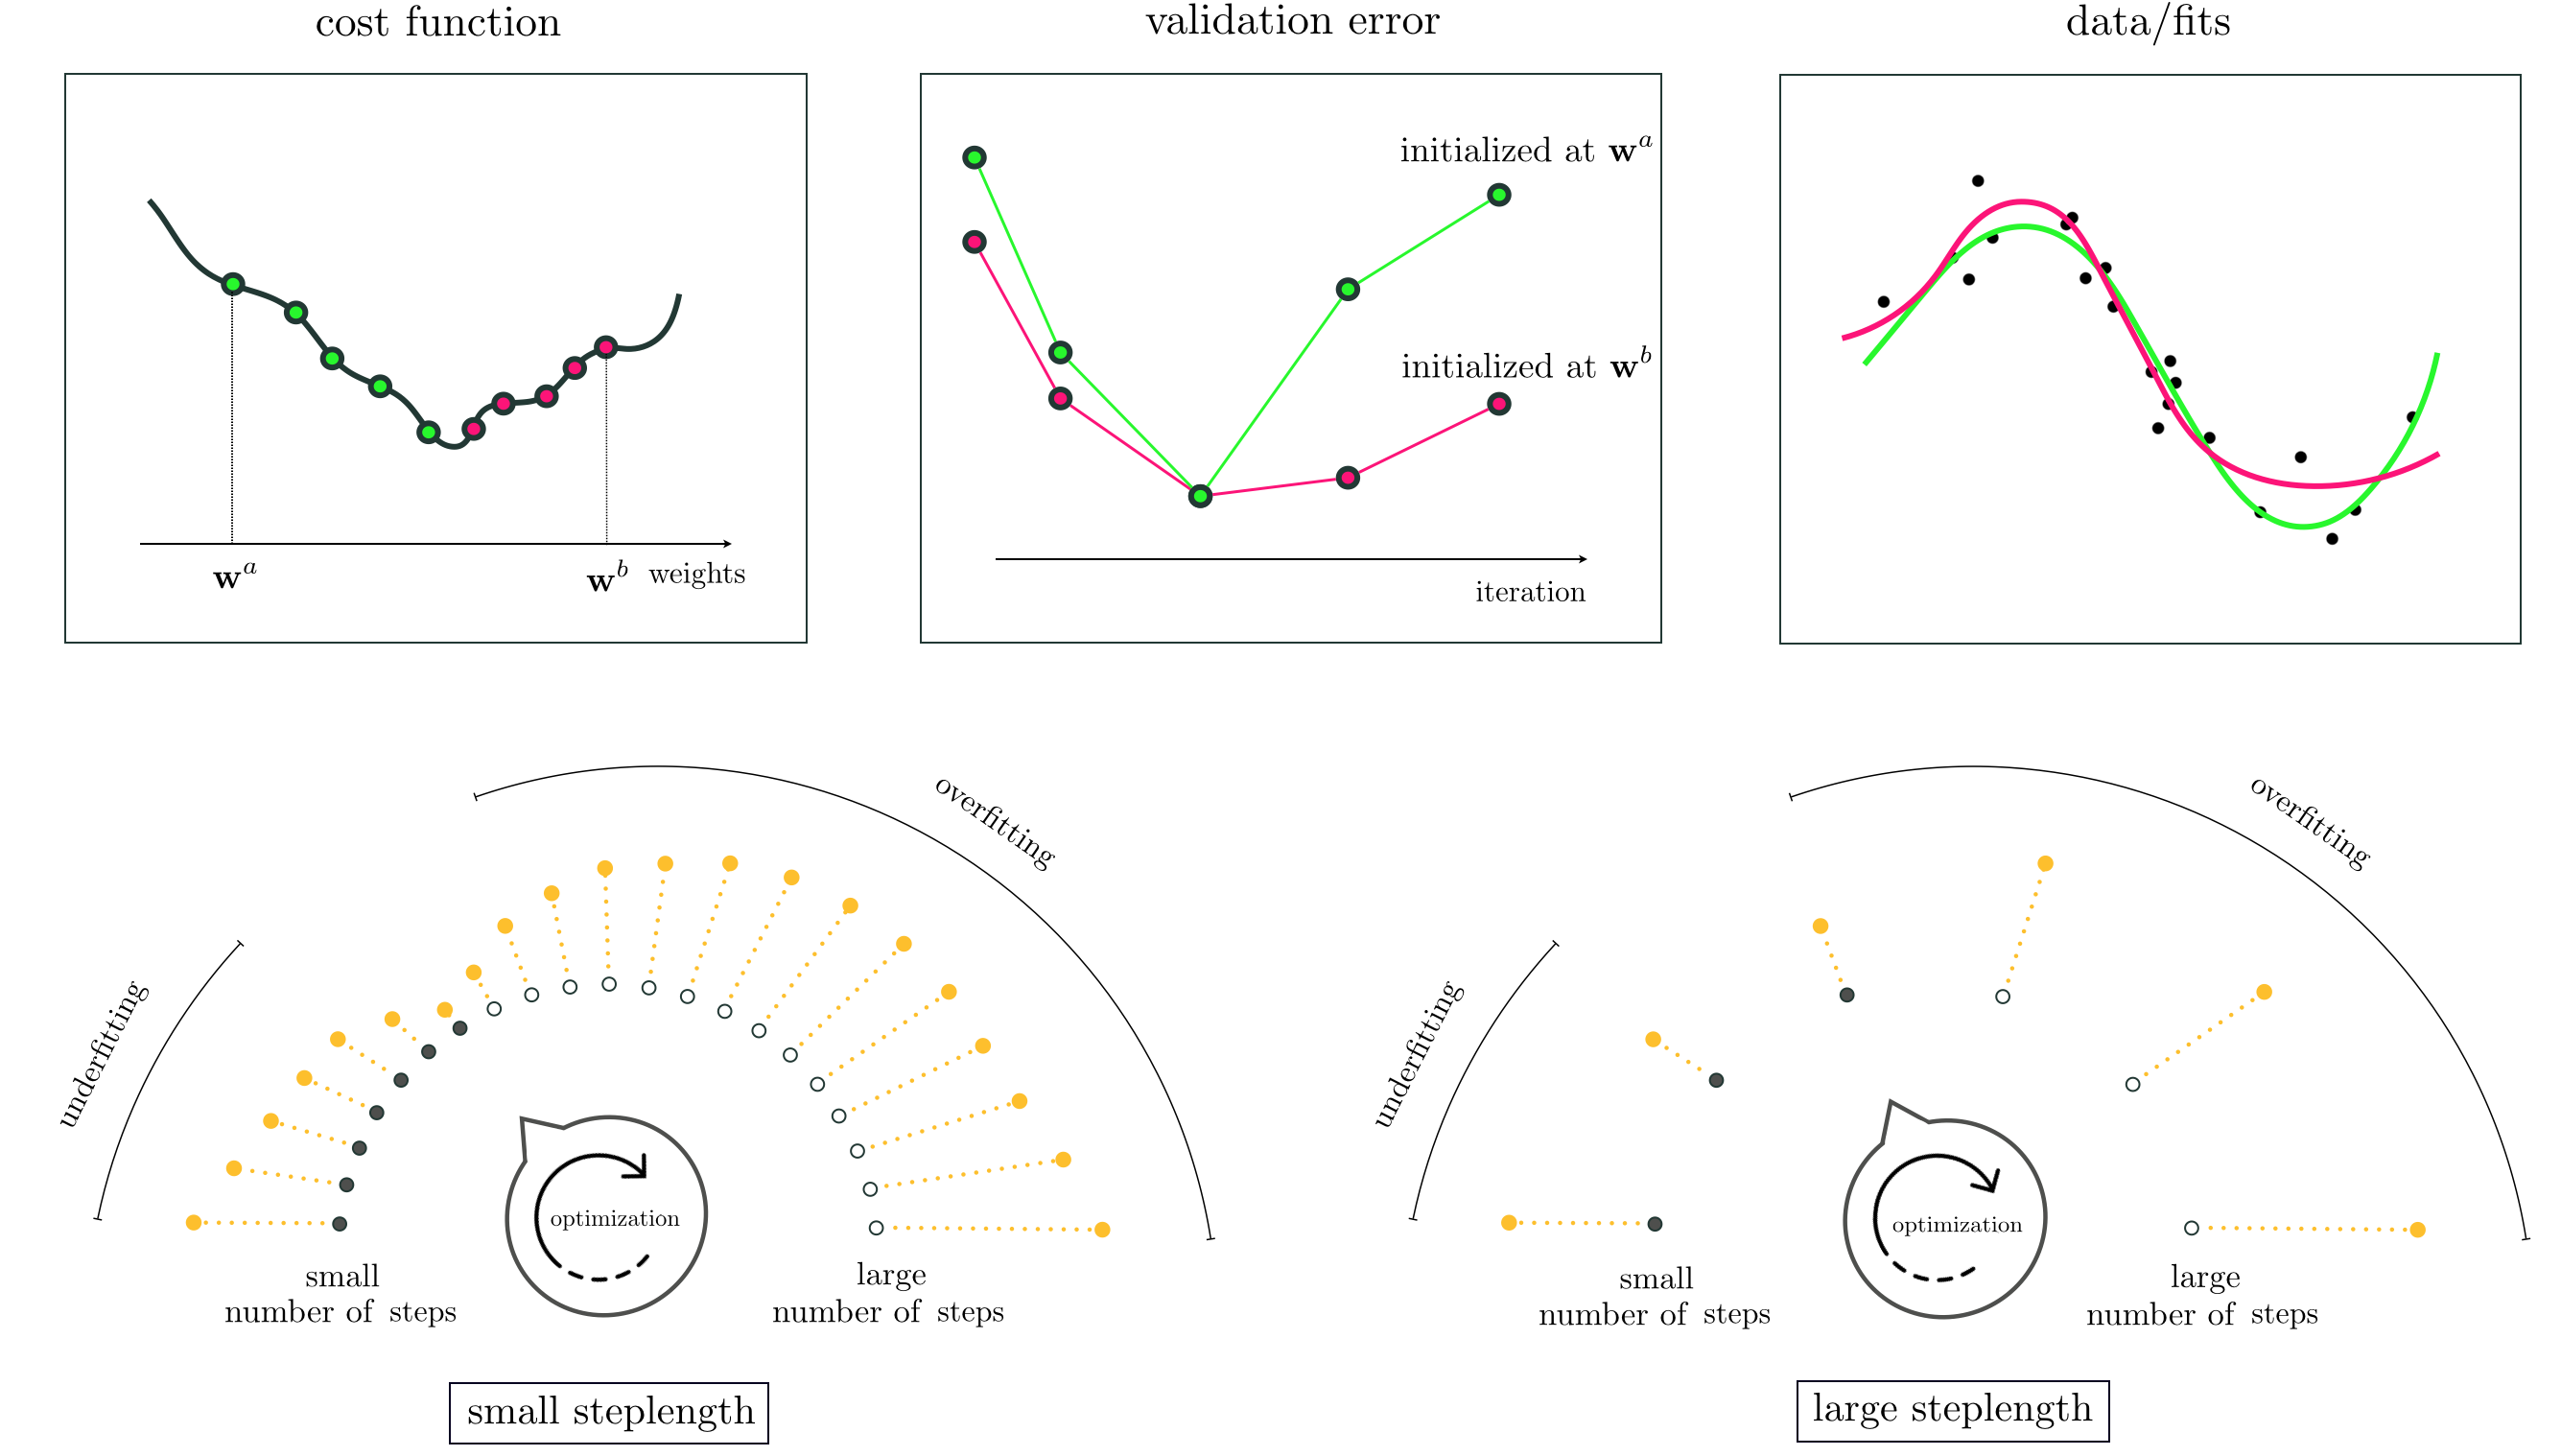

In [ ]:
Image(image_path_4)

<a id='figure-11-40'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.40 </strong> <em> 
Two subtleties associated with early stopping based regularization.  (top row) (left panel) A prototypical cost function associated with a high capacity model, with two optimization paths (shown in red and green, respectively) resulting from two local optimization runs beginning at different starting points.  (middle panel) The validation error histories corresponding to each optimization run.  (right panel) While each run produces a different set of optimal weights, and a different fit to the data (here shown in green and red respectively, corresponding to each run), these fits are generally equally representative.  (bottom row) (left panel) Taking optimization steps with a small steplength makes the early stopping procedure a fine-resolution search for optimal model complexity.  With such small steps we smoothly turn the optimization dial from left to right in search of a validation error minimizing tuned model.  (right panel)  Using steps with a large steplength makes early stopping a coarse resolution search for optimal model complexity.  With each step taken we aggressively turn the dial from left to right, performing a coarser resolution model search that potentially skips over the optimal model.
</em>
</figcaption>
</figure>

---

There are a number of important engineering details associated with
implementing an effective early stopping regularization procedure, including the following:

-  **Different optimization runs lead to different tuned models.**  The cost function topology associated with high capacity models can be quite complicated.  Different initializations can thus produce different trajectories towards potentially different minima of the cost function, and produce corresponding validation error minimizing models that differ in shape - as illustrated pictorially in the top-row of [Figure 11.40](#figure-11-40).  However, in practice these differences tend not to effect performance, and the resulting models can be easily combined or *bagged* together (see Section 11.9) to average out any major differences in their individual performance.


-  **How high should capacity be set?**  How do we know how high to set the capacity of our model when using early stopping (or any other form of) regularization based cross-validation?  In general there is no single answer.  It must simply be set at least 'high' enough that the model overfits if optimized completely.  This can be achieved by adjusting $M$ (the number of units in the model) and/or the capacity of individual units (by, for example, using shallow versus deep neural network or tree-based units).


-  **Local optimization must be carefully performed.** One must be careful with the sort of local optimization scheme used with early stopping cross-validation.  As illustrated in the bottom row of [Figure 11.40](#figure-11-40), ideally we want to turn our optimization dial smoothly from left to right, searching over a set of model complexities with a fine resolution (depicted visually in the bottom-left panel of the Figure).  This means - for example - that with early stopping we often avoid local optimization schemes that take very large steps (e.g., Newton's method - as detailed in Chapter 2) as this can result in a coarse low resolution search over model complexity that can easily skip over minimum validation models, as depicted in the bottom-right panel of the Figure.  Local optimizers that take smaller, high quality steps - like the advanced first order methods detailed in Chapter 3 - are often preferred when employing early stopping.  Moreover when employing a mini-batch/stochastic first order methods (see Section 3.11) validation error should be measured *several times per epoch* to avoid taking too large of steps without measuring validation error.
  
  
-  **When is validation error really at its lowest?** While generally speaking validation error decreases at the start of an optimization run and eventually increases (making somewhat of a 'U' shape - as depicted in [Figure 11.39](#figure-11-39)) it can certainly fluctuate up and down during optimization.  Therefore it is not all together obvious when the validation error has indeed reached its lowest point unless the optimization process is performed to completion. To deal with this peculiarity, often in practice a reasonable engineering choice is made as to when to stop based on how long it has been since the validation error has *not* decreased.  Moreover, as mentioned earlier, one need not truly halt a local optimization procedure to employ the thrust of early stopping, and can simply run the optimizer to completion and select the best set of weights from the run (that minimize validation error) after completion.  

---

## Regularizer based regularization methods

A *regularizer* is a simple function that can be added to a machine learning cost for a variety of purposes e.g., to prevent unstable learning (as we saw in Section 6.4.4), as a natural part of relaxing the support vector machine (Section 6.5.4) and multi-class learning scenarios (Section 7.3.3), and for feature selection (Section 9.7).  As we will see, the latter of these applications (feature selection) is very similar to our use of the regularizer here.

Adding a simple regularizer function like one of those we have seen in previous applications, e.g., the $\ell_2$ norm, to the cost of a high capacity model we can alter its shape and, in particular, move the location of its global minima away from their original location(s).  In general if our high capacity model is given as $\text{model}\left(\mathbf{x},\Theta\right)$, its associated cost function given by $g$, and a regularizer $h$, then the regularized cost is given as the linear combination of $g$ and $h$ as 

\begin{equation}
    g\left(\Theta \right) + \lambda h\left(\Theta\right)
    \label{equation:cross-validation-general-regularized-cost}
\end{equation}

where $\lambda$ is referred to as the *regularization parameter*.  The regularization parameter is always non-negative $\lambda \geq 0$ and controls the mixture of the cost and regularizer.  When it is set small and close to zero $\lambda \approx 0$ the regularized cost is essentially just $g$, and conversely when set very large the regularizer $h$ dominates in the linear combination (and so upon minimization we are really just minimizing it alone). In the right panel of [Figure 11.38](#figure-11-38) we show how the shape of a figurative regularized cost (and consequently the location of its minima) changes with the value of $\lambda$.

---

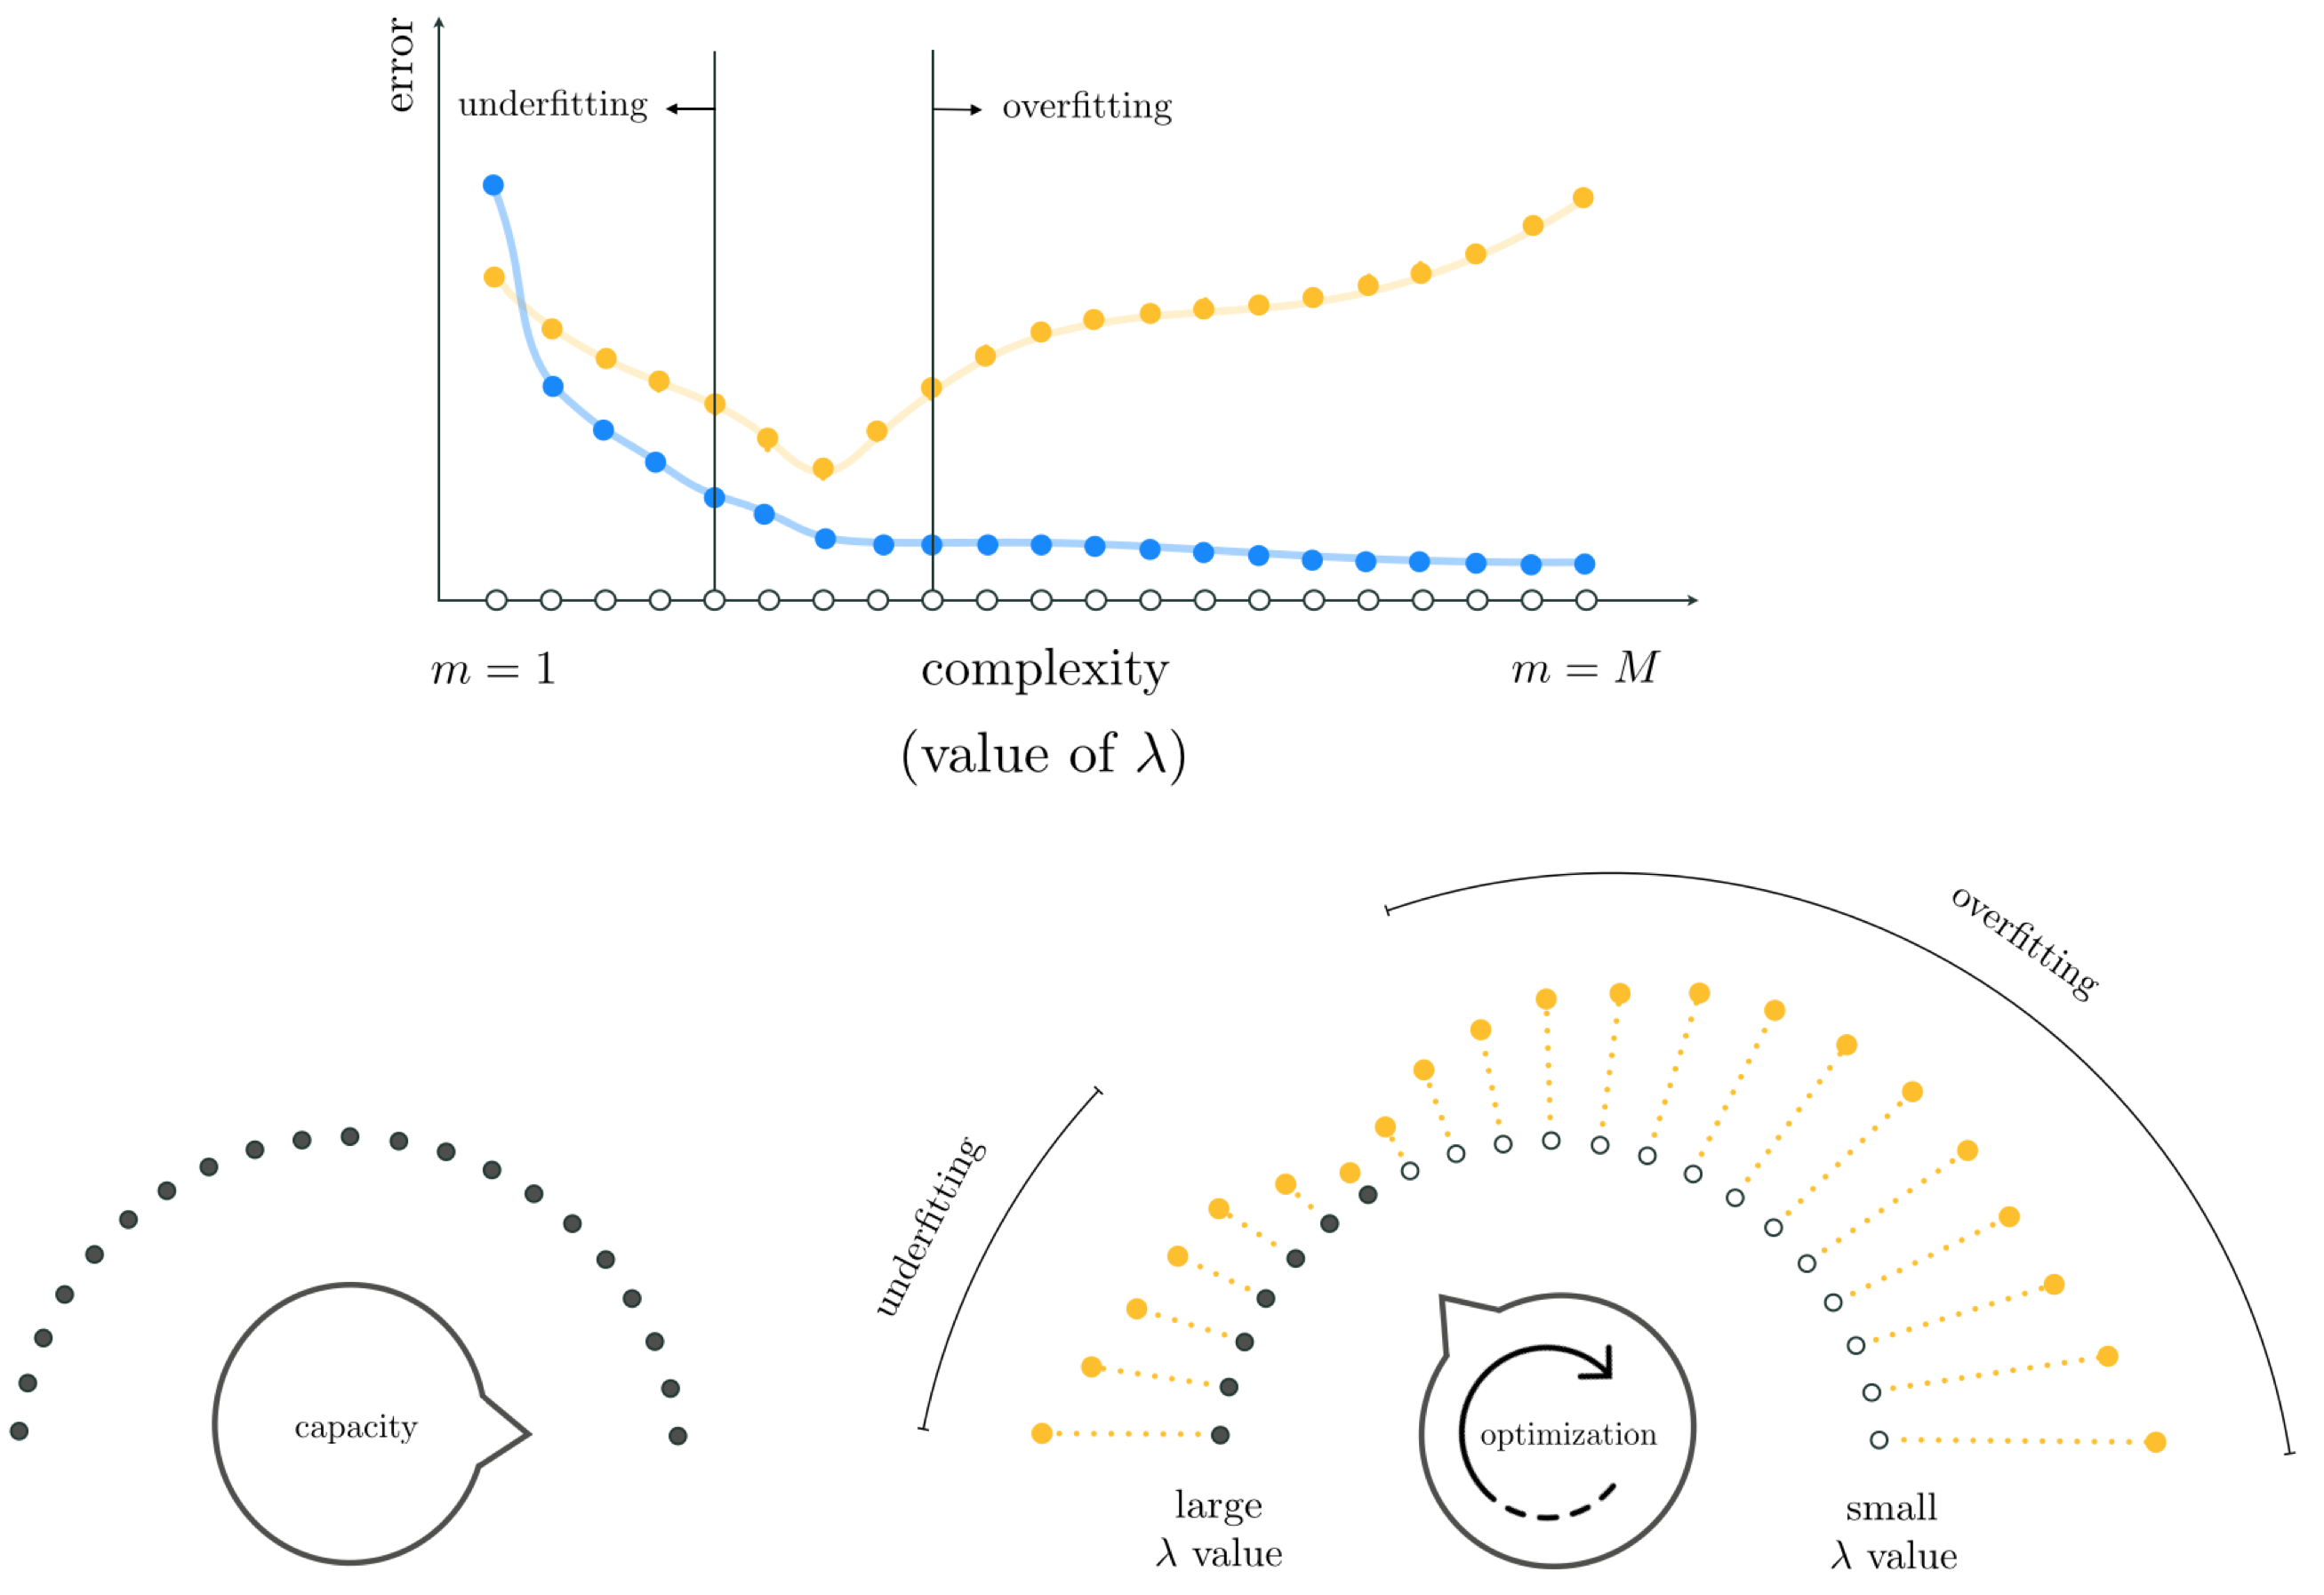

In [ ]:
Image(image_path_5)

<a id='figure-11-41'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.41 </strong> <em> 
(top panel) A prototypical pair of training / validation error curves associated with a generic run of regularizer based cross-validation.  (bottom-left and bottom-right panel) With regularizer based cross-validation we set our capacity dial all the way to the right and our optimization dial all the way to the left beginning with a large value for $\lambda$ our regularization parameter.  We then slowly move our optimization dial from left to right by decreasing the value of $\lambda$, where here each notch on the optimization dial represents the complete minimization of the corresponding regularized cost function, improving the fit our of model to the training data.  By adjusting the value of $\lambda$ (and completely minimizing each corresponding regularized cost) we slowly turn the optimization dial clockwise from left to right, gradually increasing the complexity of our tuned model, in search of a tuned model with minimum validation error.  See text for further details.
</em>
</figcaption>
</figure>

---

Supposing that we begin with a large value of $\lambda$ and try progressively smaller values (completely optimizing each regularized cost) - the corresponding training and validation error curves will in general look something like those shown in the top panel of [Figure 11.41](#figure-11-41) (remember in practice that *validation error* can oscillate, and need not take just one dip down). At the start of this procedure, using a large value of $\lambda$, the complexity of our model is quite small as the regularizer completely dominated in the regularized cost, and thus the associated minimum recovered belongs to the regularizer and not the cost function itself.  Since the set of weights is virtually unrelated to the data we are training over the corresponding model will tend to have large training and validation errors.  As $\lambda$ is decreased the parameters provided by complete minimization of the regularized cost will be closer to the global minima of the original cost itself, and so error on both training and validation portions of the data decreases while (generally speaking) the complexity of the tuned model increases.  This trend continues up until a point when the regularization parameter is small enough that the recovered parameters lie too close to that of the original cost, so that the corresponding model complexity becomes too great.  Here overfitting begins and validation error increases.

In terms of the capacity/optimization dial scheme detailed in the context of real data in Section 11.3.2, we can think of (regularizer-based) regularization as beginning with our capacity dial set to the *right* (since we employ a high capacity model) and our optimization dial all the way to the *left* (employing a large value for $\lambda$ in our regularized cost).  Here each notch on the optimization dial represents the complete minimization of the regularized cost function) for a given value of $\lambda$ - thus when the dial is turned all the way to the right (where $\lambda = 0$) we completely minimize the original cost.  With this configuration (summarized visually in the bottom panel of Figure 11.41) we allow our optimization dial to (roughly speaking) directly govern the amount of complexity our tuned models can take (here each setting of the capacity dial defines a model and each setting of the optimization dial a set of parameters of that model).  As we turn our optimization dial from left to right we *decrease* the value of $\lambda$ and *completely minimize* the corresponding regularized cost, seeking out a set of parameters that provide minimum validation error for our (high capacity) model.  This is illustrated in the bottom panels of [Figure 11.41](#figure-11-41), where we see our capacity dial set all the way to the right and our generic validation error curve wrapped around our optimization dial (as it now, roughly speaking, controls the complexity of each tuned model).

With an set of $M$ values $\left\{\lambda_m\right\}_{m=1}^M$ for our regularization parameter $\lambda$, sorted from *largest to smallest* ($\lambda_1$ being the largest value chosen and $\lambda_M$ the smallest) this scheme produces a sequence of $M$ parameter settings $\left\{\Theta_m\right\}_{m=1}^M$ and corresponding models $\left\{\text{model}\left(\textbf{x},\Theta_m\right)\right\}_{m=1}^M$ of generally *increasing* complexity. Thus, formally speaking, we can see regularizer based regularization stopping falls into the general category of cross-validation techniques outlined in Section 11.4.

---

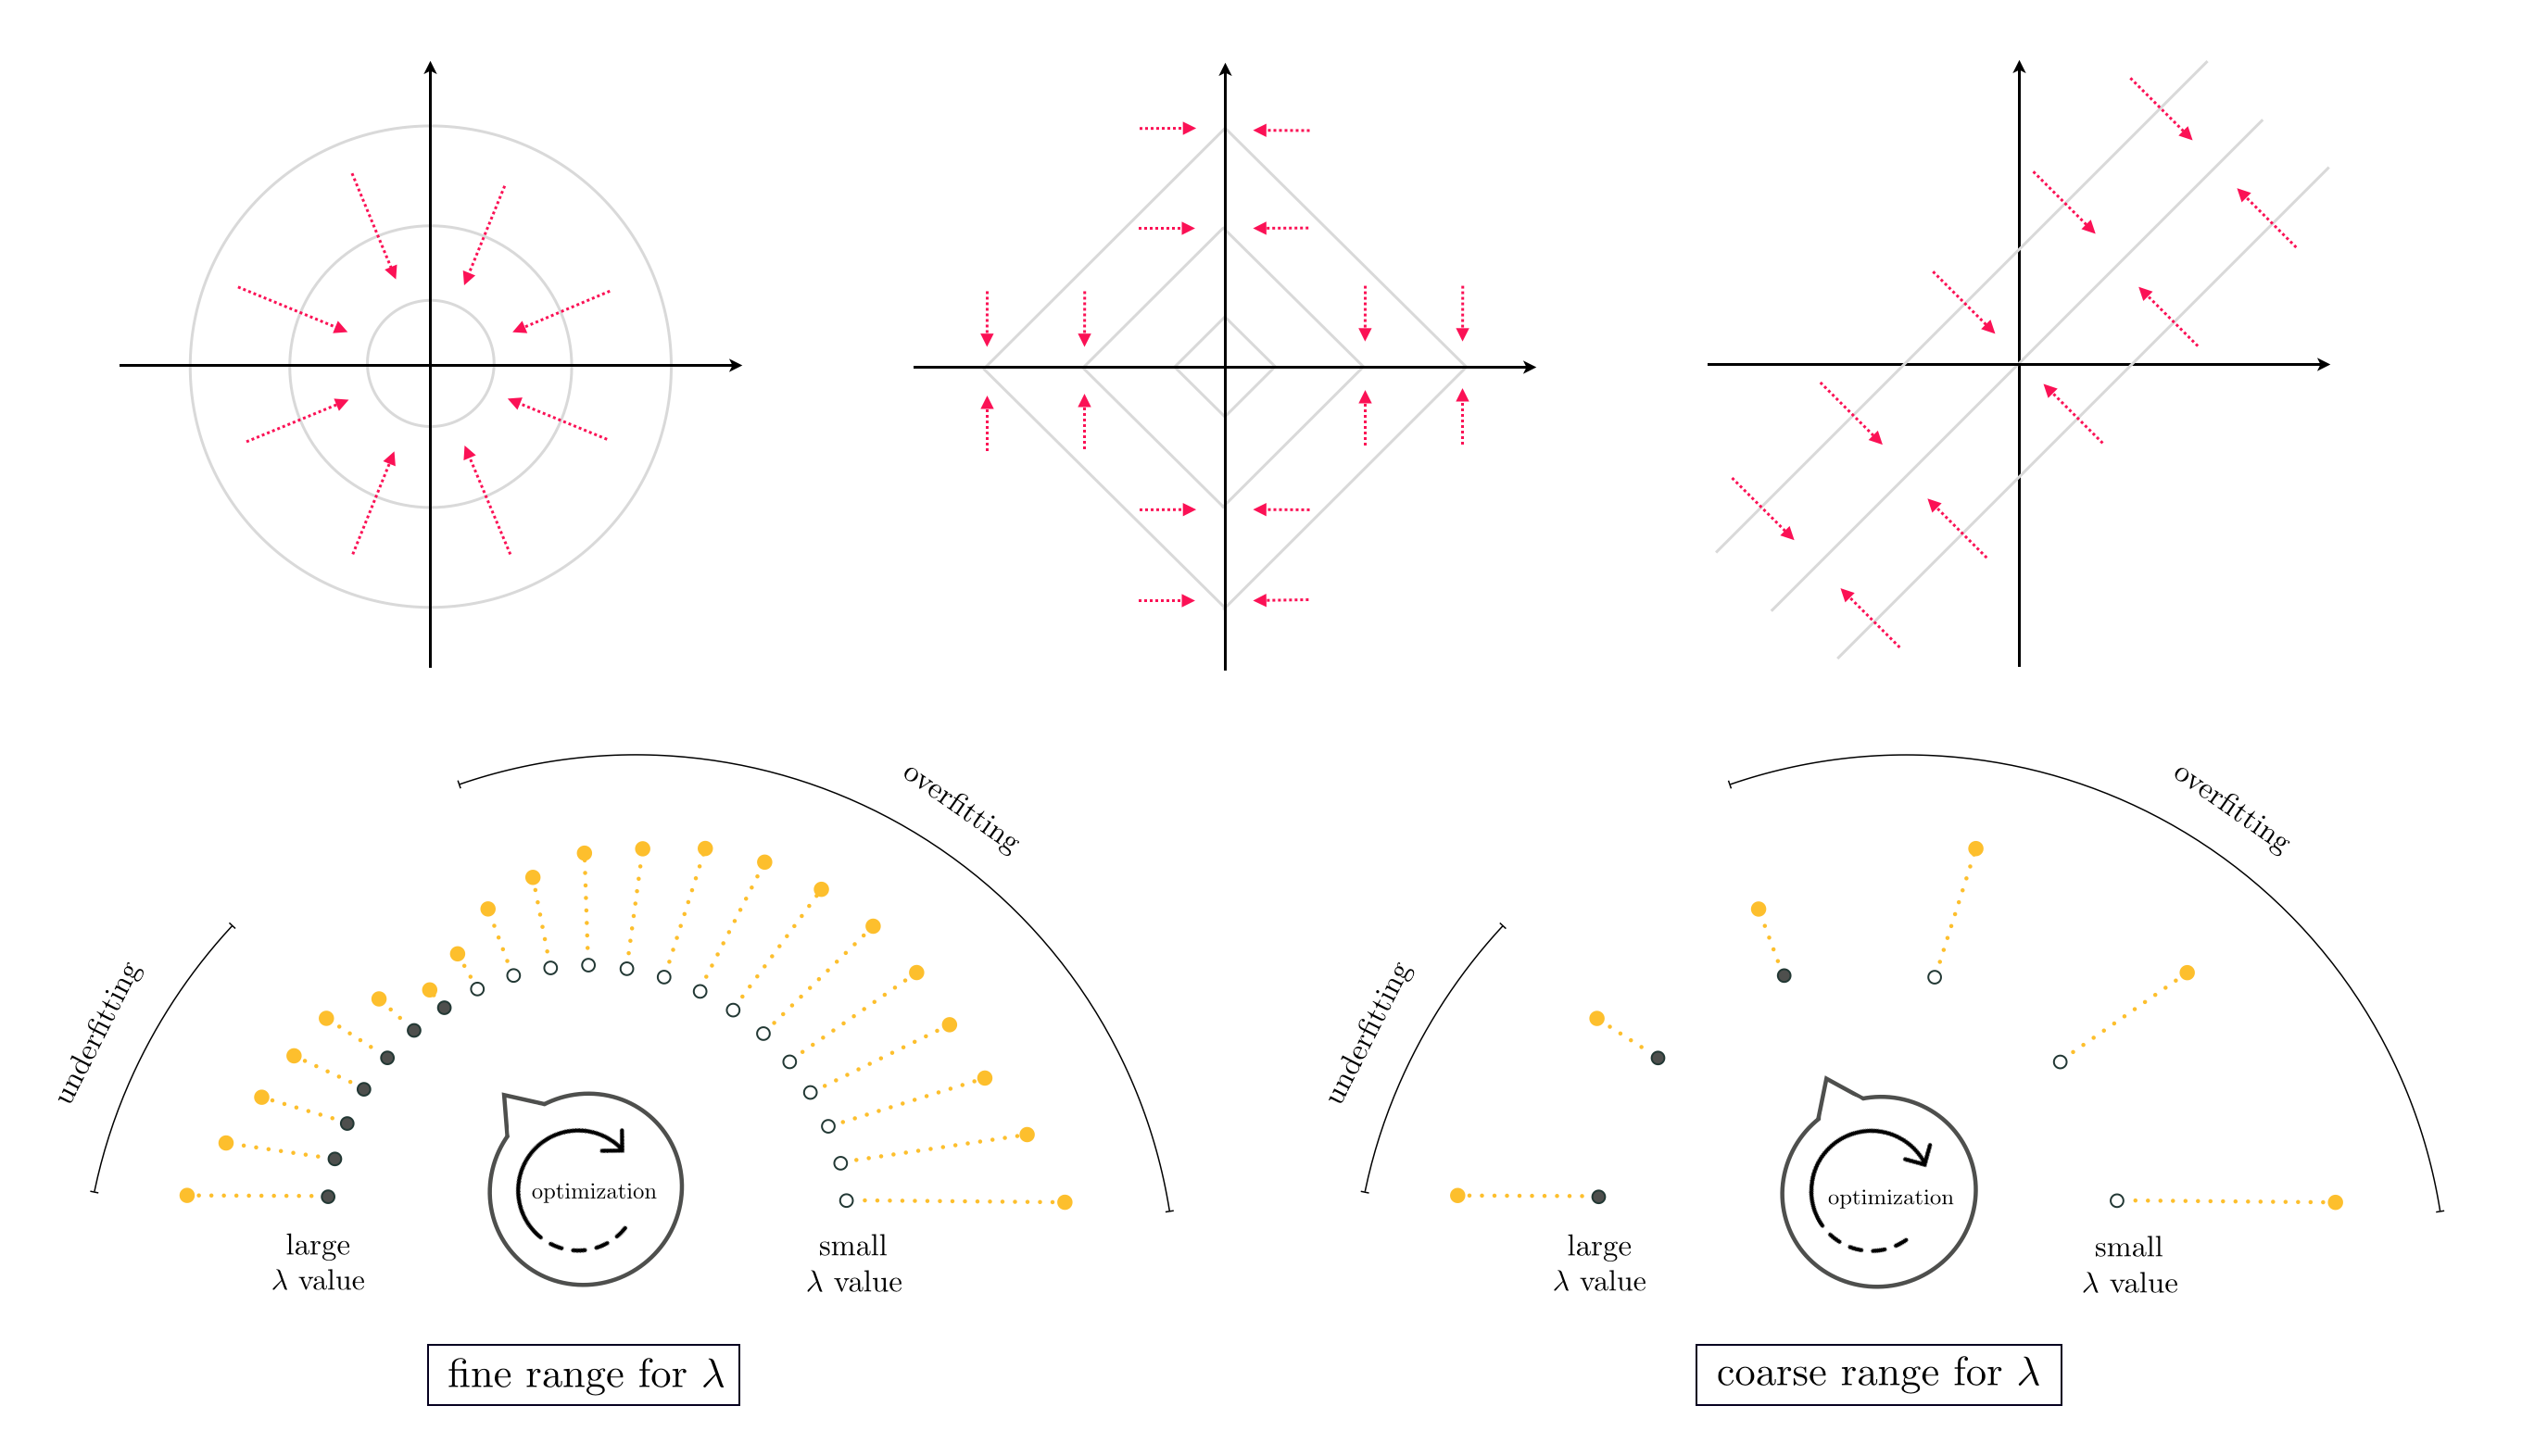

In [ ]:
Image(image_path_6)

<a id='figure-11-42'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.42 </strong> <em> 
(top row) A visual depiction of where the $\ell_2$ (left panel), $\ell_1$ (middle panel), and total variation (right panel) functions pull global minima when used as a regularizer.  These functions pull global minima towards the origin, the coordinate axes, and diagonal lines where consecutive entries are equal, respectively.  (bottom row)  (left panel) Testing out a large range and number of values for the regularization parameter $\lambda$ results in a fine resolution search for validation error minimizing weights. (right panel) A smaller number or a poorly chosen range of values can result in a coarse search that can skip over ideal weights.  See text for further details.
</em>
</figcaption>
</figure>

---

There are a number of important engineering details associated with
implementing an effective regularizer based regularization procedure, including the following:



-  **Bias weights are often not included in the regularizer.**  As with linear models as discussed in Section 9.7, often only the non-bias weights of a general model are included in the regularizer.  For example suppose that we employ fixed-shape units and hence our parameter set $\Theta$ contains a single bias $w_0$ and feature-touching weights $w_1,\,w_2,\,...,w_B$.  If we then regularize our cost function $g\left(\Theta\right)$ using the squared $\ell_2$ norm our regularized cost would take the form  $g\left(\Theta\right) + \lambda \sum_{b=1}^Bw_b^2$. When employing neural network units we follow the same pattern, but here we have far more bias terms to avoid including in the regularizer. For example, if we use single-hidden-layer units of the form $f_b\left(\mathbf{x}\right) = \text{tanh}\left(w_{b,0} + w_{b,1}x_1 + \cdots + w_{b,\,N}x_N\right)$ the term $w_{b,0}$ - internal to the unit - is a bias term we also do not want included in our regularizer.  Thus, to regularize a cost function including these units using the squared \(\ell_2\) norm we have $g\left(\Theta\right) + \lambda \sum_{b=1}^Bw_b^2 + \sum_{b=1}^B\sum_{n=1}^N w_{j,n}^2$.



-  **Choice of regularizer function.** Note that while the simple quadratic $\ell_2$ norm is a very popular regularizer, one can - in principle - use any simple function as a regularizer.  For particular applications other popular choices of regularizer functions include the absolute value or $\ell_1$ norm $\Vert \mathbf{w} \Vert_1$, which tends to produce *sparse* weights, and the *total variation* $\sum_{n=1}^{N-1} \vert w_{n+1} - w_n\vert$ which tends to produce *smoothly varying* weights.  We often use the simple quadratic regularizer to incentivize weights to be *small*, as we naturally do with two class and multi-class logistic regression.  Each of these different kinds of regularizers tends to pull the global minima of the sum towards different portions of the input space - as illustrated in the top row of [Figure 11.42](#figure-11-42) for the quadratic (left panel), $\ell_1$ norm (middle panel), and total variation norm (right panel).



-  **Choosing the range of $\lambda$ values.** Analogously to what we saw with early stopping and boosting procedures previously, with regularization we want to perform our search as carefully as possible, turning our optimization dial as smoothly from right to left in search of our perfect model.   This desire translates directly to both the range and number of values  $\left\{\lambda_m\right\}_{m=1}^{M}$ that we test out, e.g., the higher the resolution (the more values we try within a given range) the smoother we turn our cross-validation dial from right to left (as depicted visually in the bottom-left panel of [Figure 11.42](#figure-11-42)).   The limit on how many values we can try is often limited by computation and time restrictions, since *for every value of $\lambda$ tried a complete minimization of a corresponding regularized cost function must be performed*.  This can make regularizer based cross-validation very computationally expensive.  On the other hand, trying too few of values can result in a coarse search for weights providing minimum validation error, increasing the possibility that such weights are skipped over entirely (as depicted in the bottom-right panel of [Figure 11.42](#figure-11-42)).

Below we illustrate the use of regularizer based regularization on a simple example.

---

#### <span style="color:#a50e3e;">Example 11.14:</span>   Tuning a regularization parameter for regression

 In this example we use a quadratic regularizer to fit a proper nonlinear regression to our toy sinusoidal dataset.  Here the training set is shown colored in light blue, and the validation points are shown colored yellow. We use a high capacity model (with respect to this data), here a $B = 10$ degree polynomials, and $100$ values of $\lambda$ between $0$ and $1$ (completely minimizing the corresponding regularized cost in each instance).  As the value of $\lambda$ increases the fit provided by the weights recovered from the global minimum of each regularized cost function is shown in red, while the corresponding training and validation errors are shown in blue and yellow, respectively. In this simple experiment, a value somewhere around $\lambda \approx 0.3$ appears to provide the lowest validation error and corresponding best fit to the dataset overall.

In [ ]:
# # uncomment to re-render animation
# import copy

# # load in dataset
# data = np.loadtxt(data_path_1,delimiter = ',')
# x = data[:-1,:]
# y = data[-1:,:] 

# # start process
# num_units = 100
# degree = 10
# train_portion = 0.66
# lambdas = np.linspace(0,1,num_units)

# runs1 = []
# w = 0
# for j in range(num_units):
#     lam = lambdas[j]
    
#     # initialize with input/output data
#     mylib1 = superlearn_setup.Setup(x,y)
    
#     # define feature transforms
#     mylib1.choose_features(name = 'polys',degree = degree)

#     # standard normalize input
#     mylib1.choose_normalizer(name = 'standard')

#     # split into training and validation sets
#     if j == 0:
#         # make training testing split
#         mylib1.make_train_valid_split(train_portion = train_portion)
#         train_inds = mylib1.train_inds
#         valid_inds = mylib1.valid_inds

#     else: # use split from first run for all further runs
#         mylib1.x_train = mylib1.x[:,train_inds]
#         mylib1.y_train = mylib1.y[:,train_inds]
#         mylib1.x_valid = mylib1.x[:,valid_inds]
#         mylib1.y_valid = mylib1.y[:,valid_inds]
#         mylib1.train_inds = train_inds
#         mylib1.valid_inds = valid_inds
#         mylib1.train_portion = train_portion

#     # choose cost
#     mylib1.choose_cost(name = 'least_squares',lam=lam)

#     if j == 0:
#         # fit an optimization
#         mylib1.fit(optimizer = 'newtons_method',max_its = 1,verbose = False)
#     else:
#         mylib1.fit(optimizer = 'newtons_method',max_its = 1,verbose = False,w=w,epsilon=10**(-12))

#     # add model to list
#     runs1.append(copy.deepcopy(mylib1))
#     w = mylib1.w_init
    
# # animate the business
# frames = 100
# demo1 = section_11_6_helpers.Visualizer(data_path_1)
# demo1.animate_trainval_regularization(video_path_1,runs1,frames,num_units,show_history = True,fps = 10)

In [ ]:
show_video(video_path_1)

---

## Similarity to regularization for feature selection

Akin to the boosting procedure detailed in the previous Section, here the careful reader will notice how similar the regularizer based regularization framework described here is to the concept of regularization detailed for feature selection in [Section 9.7](https://jermwatt.github.io/machine_learning_refined/notes/9_Feature_engineer_select/9_7_Regularization.html).  The two approaches are very similar in theme, except here we do not select from a set of given input features but *create them ourselves based on a universal approximator*. Additionally, instead of our main concern with regularization being *human interpret-ability* of a machine learning model here we use regularization as a tool for cross-validation.